In [1]:
# Evaluation mean f1-score
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

X = np.load('data/train_data.npy')
# classes 0 - 3
y = np.genfromtxt('data/train_labels.csv', delimiter=' ', dtype=np.float32)

unique, counts = np.unique(y, return_counts=True)
print(counts) # features: 18286

[4040 1965  227  590]


[3000 1500  180  450]


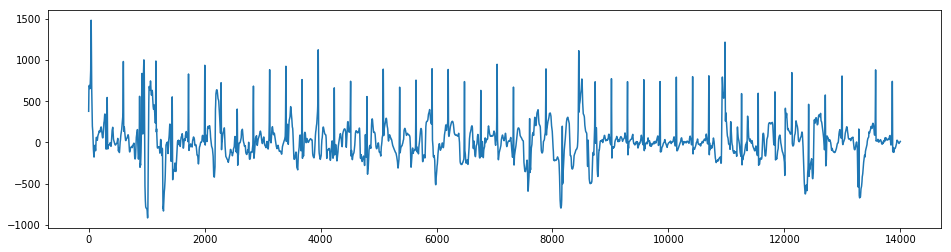

0.0
0.07417179712694225


In [27]:
from imblearn.over_sampling import SMOTE
#sm = SMOTE(random_state=384, n_jobs=-1)

ind_train = np.concatenate((np.where(y == 0)[0][0:3000], np.where(y == 1)[0][:1500], np.where(y == 2)[0][:180], np.where(y == 3)[0][:450]))
ind_test = list(set(range(0, len(X))) - set(ind_train))

X_train = np.take(X, ind_train, axis=0)
y_train = np.take(y, ind_train, axis=0)
X_test = np.take(X, ind_test, axis=0)
y_test = np.take(y, ind_test, axis=0)

#X_train, y_train = sm.fit_sample(X_train, y_train)
unique, counts = np.unique(y_train, return_counts=True)
print(counts) # features: 18286

i = 9
plt.figure(figsize=(16,4))
plt.plot(range(len(X[i][:14000])), X[i][:14000])
plt.show()
print(y[i])
# X_train, y_train, w_train = sampleIt(X_train, y_train)
# X_test, y_test, w_test = sampleIt(X_test, y_test)

c = 0
for i, x in enumerate(X):
    if np.sum(x[17000:])>0: 
        #print(y[i])
        c += 1
print(c / len(X))

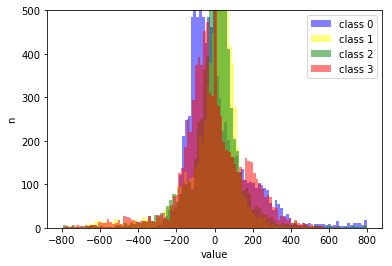

In [28]:
min_v = -800; max_v = 800;
plt.hist(X[0][(X[0] > min_v) & (X[0] < max_v) ], 100, facecolor='blue', alpha=0.5, label='class 0')
plt.hist(X[3][(X[3] > min_v) & (X[3] < max_v) ], 100, facecolor='yellow', alpha=0.5, label='class 1')
plt.hist(X[45][(X[45] > min_v) & (X[45] < max_v) ], 100, facecolor='green', alpha=0.5, label='class 2')
plt.hist(X[500][(X[500] > min_v) & (X[500] < max_v) ], 100, facecolor='red', alpha=0.5, label='class 3')
plt.ylim([0, 500])
plt.xlabel('value'); plt.ylabel('n'); plt.legend(); plt.show()

In [29]:
from sklearn.base import BaseEstimator, TransformerMixin
import random
random.seed(99)

class RandomBinsExtraction(BaseEstimator, TransformerMixin):
    """Build n bins with mean from values"""
    def __init__(self, splits=100, hist_bins=None):
        self.splits = splits
        self.hist_bins = hist_bins
        
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_new = []
        if self.hist_bins is None:
            self.hist_bins = [np.array([-1120.92739703,  -410.10302004,  -381.9367802 ,  -378.56527536,
        -174.60213944,   -44.34063315,   156.85575077,   267.69506558,
         339.42342893,   813.9679836 ,   973.56013152]), np.array([-1073.60184133,  -455.90183329,  -444.16046402,  -266.4309005 ,
        -136.41610024,    40.3241323 ,    82.42961269,   207.59071535,
         357.33894262,   797.85851412,  1104.19371508]), np.array([-1128.03563039,  -481.61721441,  -391.8380545 ,  -325.81087844,
        -100.55385922,    48.40905487,   145.29084922,   226.92310913,
         317.45573457,   679.60216005,  1042.88557759]), np.array([-975.7356248 , -552.58462036, -424.33531124, -244.59278393,
       -135.65844452,  -25.19848856,   65.99641195,  155.68679013,
        304.85466499,  524.97382413,  831.98856301]), np.array([ -964.60670382,  -477.64948448,  -385.7512008 ,  -315.21349457,
        -152.84926029,   -85.25289273,   156.42983286,   171.08830827,
         344.61128683,   632.58777948,  1012.74471941]), np.array([-1134.21396667,  -538.43695698,  -383.55196108,  -351.25518606,
        -234.1447024 ,   -76.85460874,    45.68341725,   179.81290443,
         283.45827579,   801.8892079 ,  1042.60967834]), np.array([ -992.1077973 ,  -543.54694461,  -375.95005102,  -303.90048148,
        -143.67198451,    56.16762597,    66.44392725,   207.85237126,
         380.28994569,   710.663395  ,  1041.77862555]), np.array([ -1.17059017e+03,  -4.53066930e+02,  -2.50693013e+02,
        -2.16122392e+02,  -1.31726746e+02,   1.13214948e+00,
         1.68241723e+02,   2.78649977e+02,   2.80757863e+02,
         7.83644496e+02,   9.68362007e+02]), np.array([-1087.66293359,  -549.50278667,  -408.46803696,  -277.20450193,
        -166.07720166,  -120.21777927,   127.31179008,   148.01407036,
         305.00966007,   518.83427404,   899.85406707]), np.array([-986.95299053, -503.2626519 , -433.34977809, -336.10288443,
       -183.63535388, -119.99037903,   96.05301919,  163.90039389,
        330.43404621,  765.67693595,  976.66567793]), np.array([-1099.08114631,  -528.03389226,  -335.17289441,  -212.82031621,
        -135.27839074,  -103.23247183,    58.56529893,   250.12959902,
         302.70520695,   752.02364255,  1007.3171732 ]), np.array([-1001.27139698,  -579.35034134,  -428.72446755,  -235.21167415,
        -126.52974159,  -118.11977088,    39.87136329,    74.37218865,
         244.81062741,   582.77849189,   872.47943575]), np.array([-1074.94606534,  -597.91369575,  -504.88658494,  -393.98020568,
        -130.40952056,   -74.93929184,    77.38499856,   255.65596205,
         288.87841233,   715.22901152,   975.36521957])]
            
        for row in X:
            splits = np.array_split(row[:18000], int(self.splits))
                
            features = []
            for j, split in enumerate(splits):
                i = int(j / len(splits) * len(self.hist_bins))
                features.append(np.histogram(split, bins=self.hist_bins[i])[0])
                #features.append(np.histogram(split, bins=self.hist_bins)[0])

            X_new.append(np.array(features).flatten())

        #print("features: "+str(len(X_new[0])))
        return X_new
    
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
#from sklearn.svm import LinearSVC

pipe = Pipeline([
    ('BinsExtraction', RandomBinsExtraction(splits=80)),
    ('scaler', StandardScaler()),
#    ('logreg', LogisticRegression(C=1.0, solver='liblinear', n_jobs=-1))
    ('logreg', GradientBoostingClassifier(n_estimators=50))
#      ('linearSVC', LinearSVC(C=1.0, max_iter=1000))
])

In [ ]:
from sklearn.metrics import f1_score

# pipe.fit(X_train, y_train, **{'logreg__sample_weight': w_train}); print('fitted')
pipe.fit(X_train, y_train)#; print('fitted')
y_pred = pipe.predict(X_test);
print("f1 score: {}".format(f1_score(y_test, y_pred, average='micro') ))

unique, counts = np.unique(y_pred, return_counts=True)
print(counts); #print(len(y_test[y_test==0]) / len(y_test))

# Pass score: 0.62837
# Splits 80: 0.5739644970414202 (first class 2000 rows)
# GradientBoostingClassifier, 100, 0.6505588428665352
# 30, 0.6794871794871795 / 0.7176820208023774 [2200  463   26    3]
# Smote 4x2000: 0.5197409006785935
# 45: 0.6524
# 50: 0.6542
# 60: 0.6501

In [5]:
import random
from sklearn.metrics import f1_score
def run(a):
    pipe = Pipeline([
        ('BinsExtraction', RandomBinsExtraction(splits=80, hist_bins=a)),
        ('scaler', StandardScaler()),
 #       ('logreg', LogisticRegression(C=1.0, solver='liblinear', n_jobs=2))
        ('logreg', GradientBoostingClassifier(n_estimators=50))
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test);

    score = f1_score(y_test, y_pred, average='micro')
    print("\x1b[1;31m%s\x1b[0m \t%s" % (score, a))
    
#for i in [0.01, 0.1, 1, 10]:
#    run(i)
hist_bins = [np.array([-1083.59921692,  -476.33763822,  -391.50489743,  -355.60320737,
        -158.43665552,   -14.84714956,    94.77981205,   218.64467678,
         346.5553962 ,   734.50802575,  1002.02972199]), np.array([-1019.66220701,  -523.43519633,  -379.07005136,  -331.66828082,
        -156.15875706,    18.12736061,    39.05190812,   258.69304456,
         372.82923485,   730.21415049,  1041.77824411]), np.array([-1092.05133913,  -467.36450973,  -323.77895088,  -276.7100964 ,
        -177.65586773,   -29.1918839 ,    95.14627871,   267.45422342,
         319.30367525,   752.0415106 ,  1031.95221106]), np.array([-1026.0900565 ,  -550.04804846,  -487.69032655,  -306.6158703 ,
        -166.89823442,   -61.82025277,   108.66079029,   124.07144747,
         274.9071339 ,   519.71265528,   911.63967546]), np.array([-1012.82800316,  -526.8370896 ,  -425.31935619,  -369.87368713,
        -134.25612587,  -125.16553721,   137.63442111,   221.84134438,
         308.374747  ,   698.18557519,  1044.20382967]),
            np.array([-1083.59921692,  -476.33763822,  -391.50489743,  -355.60320737,
        -158.43665552,   -14.84714956,    94.77981205,   218.64467678,
         346.5553962 ,   734.50802575,  1002.02972199]), np.array([-1019.66220701,  -523.43519633,  -379.07005136,  -331.66828082,
        -156.15875706,    18.12736061,    39.05190812,   258.69304456,
         372.82923485,   730.21415049,  1041.77824411]), np.array([-1092.05133913,  -467.36450973,  -323.77895088,  -276.7100964 ,
        -177.65586773,   -29.1918839 ,    95.14627871,   267.45422342,
         319.30367525,   752.0415106 ,  1031.95221106]), np.array([-1026.0900565 ,  -550.04804846,  -487.69032655,  -306.6158703 ,
        -166.89823442,   -61.82025277,   108.66079029,   124.07144747,
         274.9071339 ,   519.71265528,   911.63967546]), np.array([-1012.82800316,  -526.8370896 ,  -425.31935619,  -369.87368713,
        -134.25612587,  -125.16553721,   137.63442111,   221.84134438,
         308.374747  ,   698.18557519,  1044.20382967]), np.array([-1092.05133913,  -467.36450973,  -323.77895088,  -276.7100964 ,
        -177.65586773,   -29.1918839 ,    95.14627871,   267.45422342,
         319.30367525,   752.0415106 ,  1031.95221106]), np.array([-1026.0900565 ,  -550.04804846,  -487.69032655,  -306.6158703 ,
        -166.89823442,   -61.82025277,   108.66079029,   124.07144747,
         274.9071339 ,   519.71265528,   911.63967546]), np.array([-1012.82800316,  -526.8370896 ,  -425.31935619,  -369.87368713,
        -134.25612587,  -125.16553721,   137.63442111,   221.84134438,
         308.374747  ,   698.18557519,  1044.20382967])]
#hist_bins = [[-1063.23640194,  -502.03339032,  -422.5276436,   -286.42136028,   -97.20735832,   -55.16501241,   123.49800188 ,  206.09874563 ,  337.38048621,   637.69219956,   939.23230402]]
for i in range(100):
    bins_new = []
    for b1 in hist_bins:
        bins_new2 = []
        for b2 in b1:
            bins_new2.append(random.uniform(b2 - 80, b2 + 80))
        bins_new.append(np.sort(bins_new2))
    run(bins_new)

0.640070921986 	[array([-1061.18891564,  -451.19098407,  -352.62231554,  -296.99906625,
        -201.43879913,    42.8337158 ,    70.06563022,   202.62877641,
         284.52854085,   739.58777581,   922.23651616]), array([-1049.97664064,  -495.86711355,  -384.890735  ,  -339.46287817,
        -110.57930597,    -8.10064179,     9.18605346,   298.46535345,
         411.05731085,   725.09806754,  1046.74321282]), array([-1072.88273479,  -446.29327737,  -281.37229342,  -233.68030017,
        -225.61033081,  -105.89304219,    31.97052155,   236.65439593,
         332.18543231,   825.82357678,  1018.63588289]), array([-1047.01382124,  -540.89145224,  -415.96027466,  -292.53405294,
        -199.67062861,   -20.75410556,   171.05054149,   187.35213439,
         258.65858085,   467.27312451,   905.37124252]), array([-1072.2730185 ,  -585.93090838,  -433.87159767,  -313.83810328,
        -138.25945033,  -101.96160765,   170.45479414,   210.32746233,
         268.40157768,   661.95805027,  1055.

0.635933806147 	[array([-1053.57599925,  -398.67740385,  -350.4879936 ,  -347.80114775,
        -185.87709024,   -60.36156303,    25.0805164 ,   174.45930654,
         367.14532931,   694.08669577,  1080.18647742]), array([-1074.58963124,  -564.31900362,  -393.8589854 ,  -259.05119199,
        -181.57830929,   -32.3447689 ,    75.0127589 ,   192.47817152,
         368.14492415,   684.65784452,  1117.92573159]), array([-1102.0181902 ,  -466.4611155 ,  -252.32441697,  -250.80450007,
         -98.856804  ,   -40.60674606,   154.69911947,   256.98321478,
         283.62539554,   825.77090548,  1051.6282788 ]), array([-1083.14908884,  -539.05444693,  -457.11413579,  -364.88618529,
        -169.54119855,   -70.78248051,    57.98691741,   153.93222594,
         272.85750969,   535.0386251 ,   917.35999932]), array([ -994.48391143,  -482.1964745 ,  -427.89616389,  -295.47898193,
        -132.44262038,   -69.88497672,    77.0431804 ,   220.21370129,
         289.33417726,   760.37700188,  1014.

0.636524822695 	[array([-1049.56469483,  -437.95085599,  -403.79466903,  -342.11823102,
        -122.27687096,   -94.33808974,    19.60004439,   207.6073145 ,
         307.95702769,   713.87881432,  1007.85443   ]), array([ -975.16590986,  -563.7698338 ,  -367.84391461,  -324.53142996,
        -129.38745456,   -23.82042501,    80.42544848,   293.11199182,
         330.59257074,   663.34000531,  1059.21002621]), array([-1075.11074297,  -400.62910042,  -327.54853798,  -297.73339434,
        -171.18211718,    45.57881594,   146.60649427,   279.27422382,
         301.80044855,   742.69444239,  1044.9149236 ]), array([-1086.05620076,  -565.6612167 ,  -495.97851297,  -325.34325337,
        -123.2399507 ,  -100.08263152,   107.17509666,   195.37333187,
         291.21758208,   522.92482018,   948.61955637]), array([ -981.07448262,  -518.64906229,  -445.63194296,  -357.24039835,
        -138.26444007,   -66.24537181,   163.82253832,   184.13984783,
         311.86803968,   666.26960755,  1012.

0.639479905437 	[array([-1160.61219894,  -527.94338911,  -392.19755634,  -376.50792222,
         -94.30170236,   -15.08622879,    44.03150262,   167.7624042 ,
         328.40495623,   785.12699029,   951.16051423]), array([ -950.25349452,  -524.30889423,  -435.34169683,  -328.34248974,
        -193.99227303,     4.27900266,    91.87083493,   317.70864347,
         377.96033263,   781.80504684,  1115.96892201]), array([-1102.47316196,  -396.88976538,  -371.76581461,  -333.3525674 ,
        -137.13824129,   -18.33992991,    33.22936379,   269.18551377,
         276.75596692,   719.7214497 ,  1104.48864079]), array([-950.60771348, -540.23481153, -514.93198664, -349.3245761 ,
       -126.75513467,  -57.36861493,   95.07219042,  103.43450353,
        345.04072253,  479.50884448,  896.00974229]), array([-1075.99527726,  -460.92185357,  -424.17714679,  -397.73512801,
         -88.29413301,   -53.359279  ,   131.08446599,   251.92845403,
         315.80196248,   745.57579447,  1110.79904146]),

0.637115839243 	[array([-1031.90873839,  -432.73093609,  -347.88216802,  -309.54927726,
        -112.14359369,    -3.97164669,   169.25869722,   271.28524327,
         313.09807256,   707.46581587,   935.7638258 ]), array([ -961.55768798,  -583.4956375 ,  -437.90135678,  -312.1005555 ,
        -133.53626719,    13.82582748,    19.21608773,   206.21580144,
         319.83081329,   746.23038931,  1056.06814117]), array([-1103.9397904 ,  -530.42636986,  -319.78065795,  -261.64288816,
        -163.62114235,    32.7519251 ,   108.03686642,   247.67593408,
         330.36674709,   786.62913507,  1014.53297481]), array([-973.69196179, -514.72918004, -443.30809451, -376.48167188,
       -144.04711827,  -83.17405622,   51.32697551,  123.00636477,
        261.8124175 ,  521.66210286,  925.79742731]), array([-1042.64176586,  -601.95086262,  -500.27335726,  -332.12442121,
         -82.04477267,   -75.18768768,   127.7726884 ,   198.8585426 ,
         366.18969476,   684.23302288,  1070.81812365]),

0.639479905437 	[array([-1033.73016798,  -482.83809794,  -419.61559608,  -385.93579765,
        -195.12960603,   -70.06092332,    17.6434695 ,   207.65500165,
         269.86220936,   800.71082649,  1010.42196773]), array([-1040.58949806,  -564.66557163,  -423.47242268,  -341.57010108,
        -206.97859032,   -52.96433407,   -17.18709905,   328.84034042,
         388.49974207,   789.92224673,   975.14437371]), array([-1137.90045033,  -432.12950172,  -377.96120038,  -334.22464747,
        -201.32256768,   -76.36074678,    95.50653113,   262.02444787,
         296.11241732,   756.84144009,   989.79162358]), array([-993.85351445, -486.88541277, -473.08921692, -303.41724442,
       -200.37296508,    1.40855919,  131.3083215 ,  171.23319487,
        229.78060514,  477.99235113,  886.97611051]), array([ -985.73832502,  -455.0128522 ,  -417.1740624 ,  -402.33955602,
        -157.46779476,  -108.51938162,   137.23956676,   204.76412172,
         338.3192669 ,   682.49142384,  1091.78042985]),

0.63829787234 	[array([-1057.23959514,  -486.77369486,  -469.4570939 ,  -375.84832438,
        -200.06518705,     4.29458427,   134.7464081 ,   230.15849046,
         406.95162366,   704.46157808,   957.07007348]), array([ -992.17588065,  -574.61906117,  -390.403639  ,  -367.69680654,
        -231.48548041,    15.69488845,   118.9569557 ,   292.58748365,
         328.82545521,   796.4590969 ,  1065.43513292]), array([-1057.83278232,  -463.99384547,  -386.88928943,  -231.46523564,
        -203.56434878,    40.23691762,    89.29942338,   204.06927932,
         308.54012846,   735.50192668,   955.62216461]), array([-1064.01744314,  -562.09031002,  -472.82117767,  -334.30731786,
        -224.03810777,     3.01907236,    73.60336847,   142.75289138,
         253.05954839,   556.26577653,   847.60707506]), array([-1090.28785166,  -592.83226075,  -446.75027031,  -398.28297004,
        -196.77950563,  -159.47433357,   171.1986525 ,   175.95703724,
         306.07208124,   718.6131476 ,  1079.8

0.637706855792 	[array([-1047.58376923,  -536.23075739,  -336.60130736,  -321.49423253,
        -154.43428873,    42.20118934,    80.1302615 ,   174.68505782,
         307.81735794,   770.68012548,   923.71844553]), array([-1053.39679312,  -599.46129928,  -303.38188751,  -301.03170587,
        -118.10007812,   -16.38891894,    29.93574326,   198.94721901,
         296.62262499,   733.62606781,  1097.583721  ]), array([-1154.80937446,  -440.63035027,  -258.06596544,  -254.55020397,
        -163.6141189 ,    14.81653569,    45.32267271,   319.20889684,
         349.18850188,   734.28552727,  1075.4514844 ]), array([-1042.60928859,  -536.89899239,  -476.72950611,  -326.22357507,
        -202.4393466 ,  -120.80479864,    47.13506858,   167.23829788,
         198.3703072 ,   490.46258019,   916.96401553]), array([ -984.31434073,  -548.54660319,  -429.08664231,  -302.94059062,
        -106.62247378,   -70.89065505,   174.67969502,   264.94704422,
         355.37967155,   704.37149035,  1065.

0.643617021277 	[array([-1067.49609799,  -423.66999485,  -378.97488738,  -365.31613089,
        -168.60309552,   -48.02925151,   135.01099712,   187.18365476,
         284.10694999,   730.72902247,   987.14441249]), array([ -943.11956106,  -580.21127353,  -350.32574789,  -299.66236108,
        -100.03151092,    -2.51477194,    11.01039771,   232.16559294,
         340.11391166,   658.22286285,  1012.39400691]), array([-1121.89346274,  -396.31639673,  -336.5318582 ,  -303.69705568,
        -148.24914987,   -69.57828751,   128.8128806 ,   252.57683475,
         258.38350075,   745.81499827,  1003.903675  ]), array([-1093.09687619,  -565.34848487,  -521.94198205,  -360.421339  ,
        -207.66511674,  -138.72172838,   132.90939292,   141.39680801,
         260.65853112,   480.88988513,   883.13360558]), array([ -993.9232362 ,  -565.71930332,  -433.65428927,  -423.88440973,
        -122.02720278,   -93.59816171,   140.00866757,   214.40855628,
         256.55787864,   644.79653753,  1070.

0.640070921986 	[array([-1012.42190951,  -543.62833722,  -407.03882391,  -385.17731717,
        -164.21886363,    40.25771946,   162.42871493,   188.92094239,
         303.52219068,   661.20413632,  1070.68722992]), array([ -979.58296312,  -583.44484151,  -416.95162212,  -302.78426306,
        -127.19531072,    25.85662461,    30.18482376,   208.89169489,
         365.21089493,   669.62118786,  1039.83735758]), array([-1018.00793901,  -508.16066064,  -274.31544344,  -212.19878427,
        -187.31528357,   -79.27792044,   138.2193688 ,   238.26978501,
         289.10310319,   813.84164915,  1069.55357649]), array([-1088.04774665,  -538.64650607,  -465.15989029,  -329.75030522,
        -217.20026488,    -5.65634503,    61.30772762,   112.45915879,
         322.94142757,   582.81949795,   942.77893075]), array([-1084.57495709,  -560.59018247,  -419.51774043,  -416.45414404,
        -170.79185429,  -150.16742684,    82.47706733,   235.65784843,
         259.3684793 ,   680.64045119,  1016.

0.64243498818 	[array([-1125.61145996,  -479.9130696 ,  -433.81108626,  -418.9352678 ,
        -159.23544062,    19.30912236,   104.34901973,   200.40740087,
         395.17873429,   706.25222167,  1025.40783616]), array([-1072.27035035,  -488.7654742 ,  -395.64208353,  -315.68377649,
         -79.63481336,   -28.1403866 ,    26.52374026,   207.41574405,
         326.00472249,   806.88217287,  1054.3312394 ]), array([-1167.79777706,  -471.31698208,  -319.57564372,  -296.96425799,
        -141.78392448,   -36.47696797,   113.98283288,   217.09537339,
         266.99447413,   791.14709202,  1071.05945086]), array([-1050.5009786 ,  -532.72204216,  -495.08982931,  -226.63127862,
        -202.98350821,   -34.77288336,    56.73857518,   201.52711066,
         313.73663959,   537.73492197,   865.7704802 ]), array([ -969.43548975,  -558.05514918,  -412.08873568,  -359.84849293,
        -126.12366355,  -119.82660345,    69.73772812,   162.8182424 ,
         304.9181976 ,   743.0819244 ,  1019.7

0.639479905437 	[array([-1044.26581618,  -535.17643164,  -471.16932943,  -305.24879289,
        -143.72527813,   -31.79792063,    60.9565866 ,   247.91736192,
         341.45021275,   744.23313756,  1034.85350911]), array([ -987.09707101,  -454.05597853,  -382.72356021,  -268.57514736,
        -219.9242354 ,   -43.5454636 ,    84.06734876,   277.13224883,
         423.59497579,   763.26267734,  1077.72446723]), array([-1130.60850083,  -482.27410432,  -298.88554018,  -257.7524718 ,
        -182.67161234,    17.17980749,    77.90550217,   246.06628028,
         295.48860026,   810.52502193,  1058.44005585]), array([-1011.28486845,  -627.6094668 ,  -454.9241027 ,  -355.14569356,
        -104.86075963,   -54.22095809,    41.78569218,   174.67841374,
         298.91351305,   583.76948508,   905.89429526]), array([ -983.05444504,  -455.66622755,  -432.01172798,  -333.91225997,
        -198.20123921,   -57.29362391,    87.2655275 ,   162.84704116,
         369.30445367,   726.606088  ,  1097.

0.640661938534 	[array([-1074.92795081,  -413.73624347,  -369.34290919,  -337.48928058,
        -196.44162483,   -27.55749042,   151.06234524,   168.73421339,
         398.22772105,   690.20849592,  1031.81325505]), array([ -988.38753559,  -495.82552122,  -435.19312143,  -272.03617673,
        -102.94637923,    40.51991346,    70.18345559,   239.74155261,
         386.08055805,   713.63648007,  1078.58315806]), array([-1015.09303172,  -541.83925953,  -372.59952798,  -202.19982204,
        -196.86116372,   -96.70126917,   108.27639606,   198.53307177,
         256.61754946,   677.20108239,   982.98654784]), array([-958.04787387, -515.94079143, -497.19842329, -358.73537269,
       -239.56989623,  -99.03726162,  122.42129197,  174.6948015 ,
        289.54757414,  542.89770071,  894.2157968 ]), array([-1083.2560344 ,  -459.77053573,  -421.51554144,  -312.94618429,
        -184.78486861,   -76.94632471,   172.36508594,   271.49119034,
         293.10604853,   719.41387577,  1074.26102387]),

0.640070921986 	[array([-1156.73997248,  -467.61137672,  -440.41251092,  -292.37491168,
        -190.11625594,   -92.46173954,    57.68805122,   209.21829022,
         294.68715453,   664.78455354,   985.13693005]), array([ -954.49588019,  -577.03190309,  -457.55045285,  -298.16427125,
        -215.77850223,    75.81041224,    88.8934322 ,   188.13984048,
         402.40321894,   658.34970739,  1058.86010968]), array([-1057.09933154,  -490.11345863,  -314.66281958,  -250.14587049,
        -230.26491264,   -54.22604719,   125.78063605,   272.53826084,
         391.76678037,   716.47494561,  1062.53915533]), array([-1004.77356489,  -581.82084273,  -471.30108387,  -305.13923164,
        -127.74848763,   -22.74569258,    91.09221485,   135.21613742,
         307.53341064,   447.83138632,   875.6144369 ]), array([-1002.46746541,  -580.34614025,  -442.38267129,  -378.35412517,
        -186.41936167,  -145.30238339,   106.65024364,   178.22326118,
         312.73538317,   764.3474941 ,  1052.

0.646572104019 	[array([-1089.97599855,  -454.69311854,  -440.96892653,  -370.32031557,
        -167.5431956 ,    18.92117666,    60.54940595,   199.01384636,
         332.62592616,   742.54066878,   929.83539782]), array([-1009.13697369,  -519.21408103,  -410.62235707,  -340.80393214,
         -78.26559136,   -57.34196446,   -23.79339908,   185.12960969,
         383.89937845,   754.82927506,  1072.72118535]), array([-1168.58165875,  -442.98061215,  -362.58431142,  -316.55550579,
        -164.58537066,   -72.36125014,   108.41313394,   229.55380379,
         332.44344683,   703.70294119,  1090.6084493 ]), array([-1026.59628958,  -552.07007302,  -427.57342855,  -281.08334018,
        -246.33126397,     2.6876948 ,    99.57010645,   129.48946037,
         328.50900641,   453.74448277,   941.45942093]), array([ -980.93963897,  -531.72798662,  -377.84710363,  -323.87753403,
        -201.97276747,  -153.92359801,   172.89115433,   244.68427591,
         254.84165063,   676.84631744,  1120.

0.64243498818 	[array([-1134.64246907,  -444.48816853,  -337.92486303,  -331.84507167,
         -91.07508724,    54.78203374,    97.30597208,   179.49234374,
         353.64361994,   738.98375788,   950.98831972]), array([ -987.32816009,  -587.49418311,  -425.95748126,  -309.15893327,
        -129.40929772,    23.97865788,    76.0141812 ,   277.37199123,
         440.50642192,   696.0399735 ,  1038.14346346]), array([-1084.95267685,  -514.30791383,  -347.97155181,  -344.78328305,
        -179.1476781 ,   -44.53245177,   109.58654964,   222.12559786,
         348.932391  ,   755.58923779,   969.3530237 ]), array([-989.66474308, -491.9761065 , -418.03945744, -340.18235259,
       -212.82208207, -128.16608384,  102.2015231 ,  154.84916568,
        345.23381832,  468.30800117,  924.34856647]), array([-977.61040204, -535.93421343, -361.82431648, -358.37725393,
       -198.16734088, -119.32724719,  177.31959518,  267.627596  ,
        336.69336257,  621.41679797,  970.48545016]), array([-102

0.637706855792 	[array([-1104.79103481,  -462.12911526,  -403.32976716,  -344.09385899,
        -100.0143383 ,   -28.53047944,   144.72543791,   175.14594034,
         292.08667023,   676.94649997,   976.71742732]), array([-1054.93272181,  -455.77842505,  -371.10471173,  -270.85228967,
        -224.43138643,   -46.28566816,    40.32925981,   307.44888645,
         329.06288873,   762.34768408,  1039.76861313]), array([-1021.84222829,  -526.04612732,  -340.87598192,  -225.70431758,
        -104.62911018,    -5.74877678,    60.91849265,   255.55859504,
         360.03041474,   725.52669303,   988.58798456]), array([-1080.22521919,  -599.61351049,  -556.17934528,  -316.21671153,
        -199.55281285,   -30.49633628,    47.78010682,    57.65917934,
         195.12516636,   454.2359829 ,   916.63646883]), array([-1091.75767996,  -551.72484772,  -466.74867171,  -396.10043106,
        -173.14171668,   -51.63186754,    87.72068727,   157.66573381,
         313.28604839,   705.05486023,  1123.

0.64243498818 	[array([-1054.69655459,  -410.01516015,  -402.08533132,  -390.32693273,
        -127.71252937,    57.48384052,   147.1839275 ,   268.14057636,
         359.66246464,   680.35124372,  1036.19783088]), array([-1067.45903879,  -448.34689495,  -350.19302087,  -313.12197393,
        -179.58597481,   -27.08178002,    28.36581565,   276.53990037,
         294.25249192,   734.90928208,  1034.47938288]), array([-1025.38554861,  -454.59257358,  -306.55085365,  -305.37108891,
        -210.48595671,    45.70257273,    48.65826259,   199.528591  ,
         250.44814174,   780.22548804,  1038.89018255]), array([-1072.66564869,  -563.28782038,  -447.07283251,  -248.2660336 ,
        -155.76467777,   -72.04966899,   119.30805609,   174.06526797,
         278.59615216,   455.95531361,   965.09633169]), array([-1016.53263922,  -467.10966798,  -430.02981405,  -364.64869283,
        -183.46880769,   -88.0738764 ,   104.30621083,   203.71441841,
         315.3104508 ,   723.35145174,   968.6

0.638888888889 	[array([-1083.107765  ,  -401.43121847,  -387.82038979,  -307.75855986,
        -227.9433747 ,    10.95121998,   113.08847835,   187.80886051,
         382.16643768,   813.40207439,  1025.28098937]), array([-1072.04157074,  -518.10915916,  -335.48914163,  -257.44215399,
        -104.8078842 ,   -19.90322853,    44.86759324,   254.52855032,
         346.48463928,   803.76461999,   973.79458176]), array([-1123.96704848,  -410.4416326 ,  -332.4711801 ,  -282.12399607,
        -122.58430854,   -15.90281337,   168.99228517,   199.50377083,
         358.33690684,   808.87355784,  1031.87395471]), array([-1104.25687183,  -575.67343716,  -554.45494647,  -249.84147981,
        -181.24266078,  -101.18099557,    82.94206052,   180.4138273 ,
         199.57264681,   540.89754926,   939.42828692]), array([-1051.07713228,  -601.56750961,  -479.6711185 ,  -325.37520105,
        -176.31568453,  -156.87769694,   203.27120882,   242.79219318,
         353.05797903,   747.32182272,  1015.

0.640661938534 	[array([-1046.16151553,  -400.06487787,  -363.50846313,  -339.11449701,
         -92.11411077,    57.91950957,   158.18637414,   165.37907028,
         366.57076545,   720.94705582,  1033.11493979]), array([-1038.18458298,  -464.53808559,  -445.51321402,  -276.19279955,
         -99.68854241,   -27.60853349,     4.38514014,   301.98718573,
         345.21363807,   763.05623164,  1016.75089175]), array([-1168.96609969,  -388.20527771,  -376.36477418,  -314.19897258,
         -97.80071818,   -87.93373965,   106.58738317,   188.49449733,
         313.59905177,   712.14511452,   985.78054267]), array([-1012.16386025,  -552.10820772,  -501.28207534,  -307.70078554,
        -110.18741145,   -93.9212167 ,    82.85512051,   163.30661449,
         338.21152746,   445.19850125,   876.94205635]), array([ -985.74966915,  -497.72664347,  -452.05118484,  -366.15827379,
        -177.68147359,  -137.42255731,   110.14190778,   142.17177548,
         249.81832041,   737.32001608,  1021.

0.64243498818 	[array([-1150.73697994,  -421.51436292,  -380.62737659,  -326.27761159,
        -107.01537324,    38.15502872,   103.0102886 ,   285.29280403,
         422.89720653,   713.74531881,   988.26752029]), array([-992.2239793 , -464.84364122, -404.01711986, -347.8744756 ,
       -232.39886226,   23.13301094,   84.47973168,  225.47561618,
        430.85896793,  665.62525478,  989.42463695]), array([-1044.56134187,  -432.91200697,  -350.59972511,  -215.27454321,
        -204.06517434,     1.80696166,    38.36696241,   218.50457203,
         353.13069262,   708.45689107,  1043.95384472]), array([-1100.49631768,  -542.14476153,  -541.04000384,  -231.01673066,
        -187.73002089,  -110.95009883,    69.85373267,   144.77570217,
         337.65731708,   446.6250712 ,   917.80136784]), array([ -935.43804049,  -463.63139598,  -410.85148788,  -386.06166622,
        -164.65847201,  -157.92677187,   147.81806084,   168.53190121,
         235.46904831,   708.29085318,  1069.52644401]), 

0.634160756501 	[array([-1072.9973588 ,  -404.90246733,  -314.2672183 ,  -297.67348092,
        -156.45387763,     4.73299503,   124.35049617,   290.5404825 ,
         358.37615084,   692.78059689,   989.74887523]), array([ -943.35039246,  -449.74091584,  -364.56000375,  -341.9635024 ,
        -175.1952124 ,   -27.15095406,    28.65894875,   204.21630956,
         313.34927323,   724.12683024,  1077.7025418 ]), array([-1076.58085734,  -514.29298423,  -263.10782247,  -254.1415982 ,
        -222.05392094,    50.13323743,   122.50509795,   256.5293307 ,
         292.44795926,   777.5024591 ,  1002.38120732]), array([-962.41855806, -529.16526427, -433.28038414, -255.61579994,
       -163.80149354, -128.06904866,  177.53046104,  181.59606257,
        198.56412718,  440.13123085,  883.43829658]), array([-1060.42055541,  -533.91307729,  -501.05377219,  -384.29001206,
        -199.83960043,  -102.71052295,   100.45458561,   142.49454446,
         339.41171404,   685.1656113 ,  1075.39984765]),

0.644799054374 	[array([-1082.14396262,  -550.52141069,  -433.58896874,  -422.55433792,
        -122.68329971,   -48.19105139,    78.53373927,   175.59598646,
         307.56826129,   807.87968748,   978.38941174]), array([ -982.35363707,  -464.65444151,  -350.03447288,  -277.01563845,
         -84.36493114,   -12.7954222 ,    44.16831119,   208.63391663,
         294.49406434,   704.46396563,  1009.8621247 ]), array([-1154.34471734,  -435.61494871,  -290.39118103,  -287.84567806,
        -165.35032648,   -94.0972816 ,   103.488154  ,   263.31371843,
         362.19511907,   820.53478628,  1094.23921721]), array([-1056.84407158,  -530.01135363,  -509.63796339,  -238.4568772 ,
        -160.37249482,   -94.68675407,   109.79959154,   132.67248984,
         292.07038198,   519.128853  ,   957.1128864 ]), array([-1082.78310897,  -517.28927768,  -389.62378984,  -346.2281485 ,
        -164.80749808,  -141.53227976,   155.82205796,   227.62853576,
         327.02813132,   743.23443102,   984.

0.637115839243 	[array([-1034.79213839,  -500.50164076,  -439.72867341,  -325.28136801,
        -187.07983805,    12.34228803,   100.62241613,   217.88612846,
         352.83993736,   670.52862528,  1011.23150313]), array([-1020.52167892,  -453.41351571,  -439.12841005,  -272.85659322,
        -126.49250532,   -26.852268  ,    57.91228081,   275.81323825,
         429.76015642,   723.11670051,  1053.28331762]), array([-1096.44945315,  -539.99015963,  -325.94236724,  -278.59664904,
        -188.35394736,   -82.70148292,   133.96451359,   329.67374057,
         339.29316178,   820.59957706,  1046.38619579]), array([-1090.40072096,  -499.35020462,  -426.85883159,  -285.00858543,
         -97.85907562,   -54.79867446,   130.80009882,   169.79491561,
         288.14251658,   452.84913464,   862.9387969 ]), array([ -940.62726467,  -578.06089237,  -383.8801764 ,  -325.5924895 ,
        -132.93327362,  -120.2067637 ,   151.94403829,   274.03614659,
         309.68343086,   756.56533213,  1036.

0.635342789598 	[array([-1157.43233596,  -527.99592192,  -469.15514116,  -351.55497568,
        -120.58674736,    21.12152142,    25.0648775 ,   196.80967065,
         314.42821136,   793.101206  ,   966.25822032]), array([-1081.86491341,  -461.2211451 ,  -392.98687757,  -317.64594027,
        -135.89227138,     1.62542831,     4.14507972,   263.34030953,
         296.79932543,   700.74653722,   970.12590013]), array([-1052.25159124,  -411.88167171,  -345.28695722,  -324.08729808,
        -146.77400084,    41.83164845,    73.69102854,   232.39314075,
         346.81814942,   819.63330001,  1007.65547304]), array([-1032.41888271,  -613.17839034,  -429.03031654,  -277.05859248,
        -219.4803025 ,   -98.73665578,    75.20610194,   112.22553088,
         341.12258859,   531.07330602,   903.66045253]), array([ -936.25700574,  -560.87687072,  -441.35591717,  -409.4830748 ,
        -102.77588486,   -85.30674451,   106.52404272,   245.69163414,
         257.98351021,   657.14581479,  1115.

In [67]:
# Get clusters as a start for the bins
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=9, n_jobs=-1, random_state=99)#, init="k-means++")

ind = np.concatenate((np.where(y == 0)[0][0:3], np.where(y == 1)[0][:3], np.where(y == 2)[0][:3], np.where(y == 3)[0][:3]))
samples = np.take(X, ind, axis=0)
centers = []
for i, sample in enumerate(samples):
    sample = sample[(sample > -500) & (sample < 500)]
    kmeans.fit(np.array([sample]).T)
    centers.append(np.sort(np.array(kmeans.cluster_centers_).flatten()))
    print(str(i+1) + ' / ' + str(len(samples)))

if False: # use all centers
    values = np.array(centers).flatten()
    values = np.sort(values)
else: # take means of centers
    values = np.mean(centers, axis=0)

#edges = [1] # leave out 0
for center_1, center_2 in zip(values[:-1], values[1:]):
    edges.append(.5 * (center_1 + center_2))
#edges.append(1700)
"""

"""
edges

Process ForkPoolWorker-131:
Process ForkPoolWorker-132:
Process ForkPoolWorker-130:
Process ForkPoolWorker-129:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/anaconda3/lib/pyt

KeyboardInterrupt: 

In [198]:
class KnnDtw(BaseEstimator, TransformerMixin):
    """K-nearest neighbor classifier using dynamic time warping
    as the distance measure between pairs of time series arrays
    
    Arguments
    ---------
    n_neighbors : int, optional (default = 5)
        Number of neighbors to use by default for KNN
        
    max_warping_window : int, optional (default = infinity)
        Maximum warping window allowed by the DTW dynamic
        programming function
            
    subsample_step : int, optional (default = 1)
        Step size for the timeseries array. By setting subsample_step = 2,
        the timeseries length will be reduced by 50% because every second
        item is skipped. Implemented by x[:, ::subsample_step]
    """
    
    def __init__(self, n_neighbors=5, max_warping_window=10000, subsample_step=1):
        self.n_neighbors = n_neighbors
        self.max_warping_window = max_warping_window
        self.subsample_step = subsample_step
    
    def fit(self, x, l):
        """Fit the model using x as training data and l as class labels
        
        Arguments
        ---------
        x : array of shape [n_samples, n_timepoints]
            Training data set for input into KNN classifer
            
        l : array of shape [n_samples]
            Training labels for input into KNN classifier
        """
        
        self.x = x
        self.l = l
        
    def _dtw_distance(self, ts_a, ts_b, d = lambda x,y: abs(x-y)):
        """Returns the DTW similarity distance between two 2-D
        timeseries numpy arrays.

        Arguments
        ---------
        ts_a, ts_b : array of shape [n_samples, n_timepoints]
            Two arrays containing n_samples of timeseries data
            whose DTW distance between each sample of A and B
            will be compared
        
        d : DistanceMetric object (default = abs(x-y))
            the distance measure used for A_i - B_j in the
            DTW dynamic programming function
        
        Returns
        -------
        DTW distance between A and B
        """

        # Create cost matrix via broadcasting with large int
        ts_a, ts_b = np.array(ts_a), np.array(ts_b)
        M, N = len(ts_a), len(ts_b)
        cost = np.inf * np.ones((M, N))

        # Initialize the first row and column
        cost[0, 0] = d(ts_a[0], ts_b[0])
        for i in range(1, M):
            cost[i, 0] = cost[i-1, 0] + d(ts_a[i], ts_b[0])

        for j in range(1, N):
            cost[0, j] = cost[0, j-1] + d(ts_a[0], ts_b[j])

        # Populate rest of cost matrix within window
        for i in range(1, M):
            for j in range(max(1, i - self.max_warping_window),
                            min(N, i + self.max_warping_window)):
                choices = cost[i - 1, j - 1], cost[i, j-1], cost[i-1, j]
                cost[i, j] = min(choices) + d(ts_a[i], ts_b[j])

        # Return DTW distance given window 
        return cost[-1, -1]
    
    def _dist_matrix(self, x, y):
        """Computes the M x N distance matrix between the training
        dataset and testing dataset (y) using the DTW distance measure
        
        Arguments
        ---------
        x : array of shape [n_samples, n_timepoints]
        
        y : array of shape [n_samples, n_timepoints]
        
        Returns
        -------
        Distance matrix between each item of x and y with
            shape [training_n_samples, testing_n_samples]
        """
        
        # Compute the distance matrix        
        dm_count = 0
        
        # Compute condensed distance matrix (upper triangle) of pairwise dtw distances
        # when x and y are the same array
        if(np.array_equal(x, y)):
            x_s = shape(x)
            dm = np.zeros((x_s[0] * (x_s[0] - 1)) // 2, dtype=np.double)
            
            for i in range(0, x_s[0] - 1):
                for j in range(i + 1, x_s[0]):
                    dm[dm_count] = self._dtw_distance(x[i, ::self.subsample_step],
                                                      y[j, ::self.subsample_step])
                    
                    dm_count += 1
                    print(dm_count)
                    
            # Convert to squareform
            dm = squareform(dm)
            return dm
        
        # Compute full distance matrix of dtw distnces between x and y
        else:
            x_s = np.shape(x)
            y_s = np.shape(y)
            dm = np.zeros((x_s[0], y_s[0])) 
            dm_size = x_s[0]*y_s[0]
            
            for i in range(0, x_s[0]):
                for j in range(0, y_s[0]):
                    dm[i, j] = self._dtw_distance(x[i, ::self.subsample_step],
                                                  y[j, ::self.subsample_step])
                    dm_count += 1
                    print(dm_count)
        
            return dm
        
    def predict(self, x):
        """Predict the class labels or probability estimates for 
        the provided data

        Arguments
        ---------
          x : array of shape [n_samples, n_timepoints]
              Array containing the testing data set to be classified
          
        Returns
        -------
          2 arrays representing:
              (1) the predicted class labels 
              (2) the knn label count probability
        """
        
        dm = self._dist_matrix(x, self.x)

        # Identify the k nearest neighbors
        knn_idx = dm.argsort()[:, :self.n_neighbors]

        # Identify k nearest labels
        knn_labels = self.l[knn_idx]
        
        # Model Label
        mode_data = mode(knn_labels, axis=1)
        mode_label = mode_data[0]
        mode_proba = mode_data[1]/self.n_neighbors

        return mode_label.ravel(), mode_proba.ravel()
    
model = KnnDtw()
model.fit(X_train, y_train); print('fitted')
y_pred = model.predict(X_test)[0]
print(y_pred)
print("f1 score: {}".format(f1_score(y_test, y_pred, average='micro') ))

unique, counts = np.unique(y_pred, return_counts=True)
print(counts); print(len(y_test[y_test==0]) / len(y_test))

fitted


KeyboardInterrupt: 

In [203]:
from sklearn.metrics import classification_report
import matplotlib.pylab as plt
import numpy as np

class ts_classifier(object):
	
	def __init__(self,plotter=False):
		'''
		preds is a list of predictions that will be made.
		plotter indicates whether to plot each nearest neighbor as it is found.
		'''
		self.preds=[]
		self.plotter=plotter
	
	def predict(self,train,test,w,progress=False):
		'''
		1-nearest neighbor classification algorithm using LB_Keogh lower 
		bound as similarity measure. Option to use DTW distance instead
		but is much slower.
		'''
		for ind,i in enumerate(test):
			if progress:
				print(str(ind+1)+' points classified')
			min_dist=float('inf')
			closest_seq=[]
	
			for j in train:
				if self.LB_Keogh(i,j[:-1],5)<min_dist:
					dist=self.DTWDistance(i,j[:-1],w)
					if dist<min_dist:
						min_dist=dist
						closest_seq=j
			self.preds.append(closest_seq[-1])
			
			if self.plotter: 
				plt.plot(i)
				plt.plot(closest_seq[:-1])
				plt.legend(['Test Series','Nearest Neighbor in Training Set'])
				plt.title('Nearest Neighbor in Training Set - Prediction ='+str(closest_seq[-1]))
				plt.show()
	    
	    
	def performance(self,true_results):
		'''
		If the actual test set labels are known, can determine classification
		accuracy.
		'''
		return classification_report(true_results,self.preds)
	
	def get_preds(self):
		return self.preds
	
	
	def DTWDistance(self,s1,s2,w=None):
		'''
		Calculates dynamic time warping Euclidean distance between two
		sequences. Option to enforce locality constraint for window w.
		'''
		DTW={}
    
		if w:
			w = max(w, abs(len(s1)-len(s2)))
    
			for i in range(-1,len(s1)):
				for j in range(-1,len(s2)):
					DTW[(i, j)] = float('inf')
			
		else:
		    for i in range(len(s1)):
		        DTW[(i, -1)] = float('inf')
		    for i in range(len(s2)):
		        DTW[(-1, i)] = float('inf')
		
		DTW[(-1, -1)] = 0
	
		for i in range(len(s1)):
			if w:
				for j in range(max(0, i-w), min(len(s2), i+w)):
					dist= (s1[i]-s2[j])**2
					DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])
			else:
				for j in range(len(s2)):
					dist= (s1[i]-s2[j])**2
					DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])
			
		return np.sqrt(DTW[len(s1)-1, len(s2)-1])
	   
	def LB_Keogh(self,s1,s2,r):
		'''
		Calculates LB_Keough lower bound to dynamic time warping. Linear
		complexity compared to quadratic complexity of dtw.
		'''
		LB_sum=0
		for ind,i in enumerate(s1):
	        
			lower_bound=min(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
			upper_bound=max(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
	        
			if i>upper_bound:
				LB_sum=LB_sum+(i-upper_bound)**2
			elif i<lower_bound:
				LB_sum=LB_sum+(i-lower_bound)**2
	    
		return np.sqrt(LB_sum)
    
train = np.concatenate((X_train, [[i] for i in y_train]), axis=1)
test = np.concatenate((X_test, [[i] for i in y_test]), axis=1)
model = ts_classifier()
model.predict(train, test, 3, progress=True)

1 points classified


KeyboardInterrupt: 